## A Little More Data Cleanup, Creating New Features and Generating Trajectories and Trips 

In this Jupyter notebook, we refine our vessel data further. Using special techniques, we clean up the data for better quality. We also add new features, like vessel status, and use this to build detailed ship routes and trips.

In [ ]:
import pandas as pd
import geopandas as gpd
import pygeos
from datetime import datetime
import numpy as np
import random
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Read CSV files into GeoPandas DataFrames
ports = pd.read_csv('../Dataset_after/ports_new.csv')
pos = pd.read_csv('../Dataset_after/clean.csv')

In [3]:
len(ports), len(pos)

(26, 3607379)

### **A Little More Data Cleaning**

#### **In the data cleaning process, there were things we didn't notice, but they are of the utmost importance for a better Data Cleaning Procedure:**<br>

 - **Excluding Ports:** Initially, we decided to exclude the PIRAEUS - AKTI VASILIADI and PIREAUS - KENTRIKOS LIMENAS from our dataset. We did this because the half nautical mile distance, which we use as the distance criterion from the port, coincided with the geometric shape that describes the Piraeus Port. This decision prevents the creation of duplicate records in our data.
  
 - **Creating Buffer Zone:** For all other ports, we created a buffer distance of 926 nautical miles, equivalent to half a nautical mile. Then, we checked the distance from each point (waypoint). When a point matches the geometric shape that describes a port, we consider it as belonging to that port, and we record this information in a new column called port_code.
  
 - **Mapping to Piraeus:** Similarly, we follow a similar logic to save computation time. We checked points that didn't have a port_code and those that were within the geometric shape of Piraeus. In these cases, we filled in the port_code with the corresponding identifier (id) of the port from the Ports table.<br>
  
***Note***: The spatial operations described above were performed using the R-tree algorithm, which plays a pivotal role in efficiently handling our geographic dataset. The R-tree is a specialized data structure designed for spatial indexing, making it essential for managing large datasets with geographic components.

#### **How R-tree Works:**<br>
The R-tree algorithm works by organizing spatial objects, such as geographic shapes or points, into a hierarchical tree structure. This structure allows for efficient spatial queries, such as finding all points within a certain distance of a given location or identifying overlapping shapes.<br> 

Here's a simplified overview of how it operates:

- **Hierarchical Structure:** The R-tree organizes objects into a tree structure where each node represents a bounding box that encompasses a group of objects. The root node encompasses all objects, and as you descend the tree, nodes contain smaller groups of objects.

- **Bounding Boxes:** Each node's bounding box is designed to enclose all the objects within its subtree. This minimizes the number of nodes that need to be traversed during queries, making searches faster.

- **Splitting and Merging:** When a node becomes too full, it can split into multiple child nodes or merge with neighboring nodes to maintain a balanced tree structure.

- **Query Processing:** During a query, the R-tree starts at the root and descends through the tree, identifying nodes that intersect with the query area. This reduces the number of objects that need to be examined in detail.

- **Efficient Spatial Queries:** By efficiently narrowing down the search space using bounding boxes, the R-tree significantly accelerates spatial queries, making it an indispensable tool for tasks like geospatial data cleaning, location-based services, and geographic analysis.

In summary, the R-tree algorithm enhances the performance of our data cleaning procedure by optimizing spatial queries and reducing computation time, ultimately improving the accuracy and efficiency of our geographic data handling.

In [4]:
# Create Points from lon and lat in the geometry data
ports = gpd.GeoDataFrame(ports, geometry=gpd.points_from_xy(ports.lon, ports.lat), crs='EPSG:4326')
pos = gpd.GeoDataFrame(pos, geometry=gpd.points_from_xy(pos.lon, pos.lat), crs='EPSG:4326')

In [5]:
pos.dtypes

id_x                     int64
vessel_id               object
t                       object
lon                    float64
lat                    float64
heading                float64
course                 float64
speed                  float64
location_geometry       object
distance_in_meters     float64
geom                    object
Δs                     float64
Δt                     float64
velocity               float64
speed_m/s              float64
velocity in knots      float64
type                     int64
speed_max                int64
geometry              geometry
dtype: object

In [6]:
ports.head()

,name,lon,lat,geometry_polygon,geometry_point,geometry
0,ZEA,23.64899,37.93486,NaN,0101000020E6100000586E693524A63740562B137EA9F7...,POINT (23.64899 37.93486)
1,SOUSAKI,23.05575,37.91680,NaN,0101000020E610000083C0CAA1450E3740857CD0B359F5...,POINT (23.05575 37.91680)
2,SIRI,24.06864,37.74283,NaN,0101000020E61000008B321B64921138406C3EAE0D15DF...,POINT (24.06864 37.74283)
3,RAFINA,24.01164,38.02345,NaN,0101000020E61000005053CBD6FA023840AC8BDB680003...,POINT (24.01164 38.02345)
4,PERAMA,23.56732,37.96085,NaN,0101000020E6100000E25D2EE23B913740492EFF21FDFA...,POINT (23.56732 37.96085)


In [7]:
pos.head()

,id_x,vessel_id,t,lon,lat,heading,course,speed,location_geometry,distance_in_meters,geom,Δs,Δt,velocity,speed_m/s,velocity in knots,type,speed_max,geometry
0,56775,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 02:52:35,23.53248,38.02678,11.0,256.9,0.0,0101000020E61000002AC6F99B50883740EC17EC866D03...,13646.902437,POINT (458818.04814661463 4208601.550547703),NaN,NaN,NaN,0.0000,NaN,89,20,POINT (23.53248 38.02678)
1,104599,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 06:10:36,23.53245,38.02678,10.0,302.7,0.0,0101000020E610000055C1A8A44E883740EC17EC866D03...,13648.848561,POINT (458815.4151503135 4208601.563782826),2.633030,11881.0,0.000222,0.0000,0.000431,89,20,POINT (23.53245 38.02678)
2,197026,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 10:28:35,23.53255,38.02612,335.0,266.9,0.0,0101000020E61000001C7C613255883740C1E270E65703...,13593.123862,POINT (458823.8237752401 4208528.29000446),73.754672,15479.0,0.004765,0.0000,0.009262,89,20,POINT (23.53255 38.02612)
3,226340,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 12:10:37,23.53175,38.02600,28.0,243.4,0.0,0101000020E6100000E3A59BC42088374017D9CEF75303...,13636.377957,POINT (458753.5428815002 4208515.328692883),71.466073,6122.0,0.011674,0.0000,0.022692,89,20,POINT (23.53175 38.02600)
4,249045,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:28:36,23.53196,38.02584,22.0,191.8,0.2,0101000020E6100000B9C7D2872E883740DE76A1B94E03...,13610.803373,POINT (458771.8847206099 4208497.483282045),25.590657,4679.0,0.005469,0.1028,0.010631,89,20,POINT (23.53196 38.02584)


### Excluding Ports

Remove the 2 ports PIRAEUS - AKTI VASILIADI and PIREAUS - KENTRIKOS LIMENAS cause the buffer zones that will be created are in the polygon of Piraeus

In [8]:
ports_df = ports[(ports['name'] != 'PIRAEUS - AKTI VASILIADI') &  (ports['name'] != 'PIREAUS - KENTRIKOS LIMENAS')]
ports_df.reset_index(drop=True, inplace=True)
ports.head()

,name,lon,lat,geometry_polygon,geometry_point,geometry
0,ZEA,23.64899,37.93486,NaN,0101000020E6100000586E693524A63740562B137EA9F7...,POINT (23.64899 37.93486)
1,SOUSAKI,23.05575,37.91680,NaN,0101000020E610000083C0CAA1450E3740857CD0B359F5...,POINT (23.05575 37.91680)
2,SIRI,24.06864,37.74283,NaN,0101000020E61000008B321B64921138406C3EAE0D15DF...,POINT (24.06864 37.74283)
3,RAFINA,24.01164,38.02345,NaN,0101000020E61000005053CBD6FA023840AC8BDB680003...,POINT (24.01164 38.02345)
4,PERAMA,23.56732,37.96085,NaN,0101000020E6100000E25D2EE23B913740492EFF21FDFA...,POINT (23.56732 37.96085)


### Creating Buffer Zone

We need to have the geometry points of ports in EPSG:2100 to achieve a consistent spatial analysis. We create the multipolygon of Pireaus and transform it also in EPSG:2100.

In [9]:
from shapely.wkb import loads

# Extract a WKB (Well-Known Binary) representation of a polygon from the 'geometry_polygon' column at index 25
polygon_wkb = ports.geometry_polygon.iloc[25]

# Convert the WKB representation into a Shapely MultiPolygon
multipolygon = loads(bytes.fromhex(polygon_wkb))

# Create a new GeoDataFrame with the MultiPolygon and set it as the active geometry column
multipolygon_gdf = gpd.GeoDataFrame({'geometry_multipolygon': [multipolygon]}, geometry='geometry_multipolygon', crs='EPSG:4326')

# Assign a 'name' value to the new GeoDataFrame, to use it for merge
multipolygon_gdf['name'] = 'PIRAEUS'

# Merge the 'ports' GeoDataFrame with the 'multipolygon_gdf' GeoDataFrame based on the 'name' column, performing a left join
ports = ports.merge(multipolygon_gdf, left_on='name', right_on='name', how='left')

# Reproject the 'multipolygon_gdf' GeoDataFrame to a different CRS (EPSG:2100)
multipolygon_gdf = multipolygon_gdf.to_crs('EPSG:2100')

In [10]:
multipolygon_gdf

,geometry_multipolygon,name
0,"MULTIPOLYGON (((466557.416 4198576.354, 466637...",PIRAEUS


<AxesSubplot:>

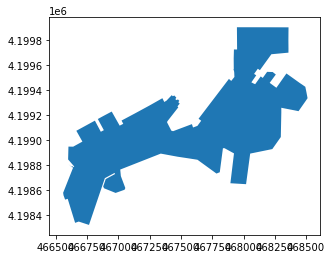

In [11]:
multipolygon_gdf.plot()

In [12]:
pos.geometry.head(1)

0    POINT (23.53248 38.02678)
Name: geometry, dtype: geometry

In [14]:
# Reproject the 'multipolygon_gdf' GeoDataFrame to a new CRS (EPSG:2100)
multipolygon_gdf = multipolygon_gdf.to_crs('EPSG:2100')

# Reproject the 'pos' GeoDataFrame to match the same CRS (EPSG:2100)
pos = pos.to_crs('EPSG:2100')
pos.geometry.head(1)

0    POINT (458818.048 4208601.551)
Name: geometry, dtype: geometry

In [15]:
str(multipolygon_gdf.geometry_multipolygon)

'0    MULTIPOLYGON (((466557.416 4198576.354, 466637...\nName: geometry_multipolygon, dtype: geometry'

We removed the Pireaus row in ports_df1.Then we create a spatial index for a subset of ports data ('ports_df1') and buffer their geometries to define buffer regions around each port. This is done to account for vessel positions near ports.

In [16]:
ports.tail(1)

,name,lon,lat,geometry_polygon,geometry_point,geometry,geometry_multipolygon
25,PIRAEUS,23.6121,37.94958,0106000020E610000004000000010300000001000000A3...,0101000020E6100000B1E1E995B29C3740C47762D68BF9...,POINT (23.61210 37.94958),"MULTIPOLYGON (((23.62112 37.93674, 23.62203 37..."


In [17]:
# We create a new DataFrame without the Pireaus port
ports_df1 = ports_df.iloc[0:len(ports_df)-1]

# Reproject the 'ports_df1' GeoDataFrame to match the same CRS with others (EPSG:2100)
ports_df1 = ports_df1.to_crs('EPSG:2100')
ports_df1.geometry.tail(1)

22    POINT (469935.474 4198750.157)
Name: geometry, dtype: geometry

**Using R-Tree Method**

In [ ]:
from shapely.geometry import Point
import rtree

# Create a spatial index for ports_df1
index = rtree.index.Index()  # Create an empty R-tree index
for i, geom in enumerate(ports_df1.geometry):
    # Insert each geometry into the R-tree index with its bounding box
    index.insert(i, geom.bounds)

# Buffer the ports_df1's geometries to create a buffer region
buffer_distance = 926  # Set the buffer distance in meters
ports_df1['buffered_geometry'] = ports_df1.geometry.buffer(buffer_distance)

# Create a GeoDataFrame with only buffered geometries
ports_df_buffered = ports_df1[['buffered_geometry']]  # Extract the 'buffered_geometry' column
ports_df_buffered = ports_df_buffered.set_geometry('buffered_geometry')  # Set it as the active geometry column
ports_df_buffered.crs = ports_df1.crs  # Set the CRS to match ports_df1

# Perform spatial join using Rtree index
joined = []  # Initialize a list to store the joined geometries
for point in pos.geometry:
    # Find potential matches using the R-tree index and bounding box of the point
    possible_matches_index = list(index.intersection(point.bounds))
    possible_matches = ports_df_buffered.iloc[possible_matches_index]  # Get potential matches
    joined.extend(possible_matches[possible_matches.intersects(point)])  # Check actual intersection

# Create the final GeoDataFrame containing the joined geometries
result_gdf = gpd.GeoDataFrame(joined)

**Using GeoPandas Spatial Indexing Method**

In [18]:
# Create spatial index for ports_df1
ports_df1_sindex = ports_df1.sindex

# Buffer the ports_df1' geometries to create a buffer region
buffer_distance = 926  # in meters
ports_df1['buffered_geometry'] = ports_df1.geometry.buffer(buffer_distance)

# Create a GeoDataFrame with only buffered geometries
ports_df_buffered = ports_df1[['buffered_geometry']]
ports_df_buffered = ports_df_buffered.set_geometry('buffered_geometry')
ports_df_buffered.crs = ports_df1.crs 

# Spatial join using the buffered geometries and spatial index
joined = gpd.sjoin(pos, ports_df_buffered, how='left', op='intersects')

# Display the result
joined.head(12)

,id_x,vessel_id,t,lon,lat,heading,course,speed,location_geometry,distance_in_meters,geom,Δs,Δt,velocity,speed_m/s,velocity in knots,type,speed_max,geometry,index_right
0,56775,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 02:52:35,23.53248,38.02678,11.0,256.9,0.0,0101000020E61000002AC6F99B50883740EC17EC866D03...,13646.902437,POINT (458818.04814661463 4208601.550547703),NaN,NaN,NaN,0.0000,NaN,89,20,POINT (458818.048 4208601.551),NaN
1,104599,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 06:10:36,23.53245,38.02678,10.0,302.7,0.0,0101000020E610000055C1A8A44E883740EC17EC866D03...,13648.848561,POINT (458815.4151503135 4208601.563782826),2.633030,11881.0,0.000222,0.0000,0.000431,89,20,POINT (458815.415 4208601.564),NaN
2,197026,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 10:28:35,23.53255,38.02612,335.0,266.9,0.0,0101000020E61000001C7C613255883740C1E270E65703...,13593.123862,POINT (458823.8237752401 4208528.29000446),73.754672,15479.0,0.004765,0.0000,0.009262,89,20,POINT (458823.824 4208528.290),NaN
3,226340,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 12:10:37,23.53175,38.02600,28.0,243.4,0.0,0101000020E6100000E3A59BC42088374017D9CEF75303...,13636.377957,POINT (458753.5428815002 4208515.328692883),71.466073,6122.0,0.011674,0.0000,0.022692,89,20,POINT (458753.543 4208515.329),NaN
4,249045,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:28:36,23.53196,38.02584,22.0,191.8,0.2,0101000020E6100000B9C7D2872E883740DE76A1B94E03...,13610.803373,POINT (458771.8847206099 4208497.483282045),25.590657,4679.0,0.005469,0.1028,0.010631,89,20,POINT (458771.885 4208497.483),NaN
5,252333,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:40:36,23.53216,38.02584,4.0,214.0,0.0,0101000020E6100000473D44A33B883740DE76A1B94E03...,13597.741546,POINT (458789.4382538119 4208497.394972182),17.553755,720.0,0.024380,0.0000,0.047391,89,20,POINT (458789.438 4208497.395),NaN
6,257233,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:58:37,23.53271,38.02582,6.0,89.5,0.5,0101000020E61000008E40BCAE5F88374097CADB114E03...,13560.386888,POINT (458837.69932105555 4208494.933234184),48.323812,1081.0,0.044703,0.2570,0.086895,89,20,POINT (458837.699 4208494.933),NaN
7,263839,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 14:22:36,23.53189,38.02576,24.0,155.1,0.3,0101000020E6100000C7116BF129883740C1C58A1A4C03...,13609.453840,POINT (458765.6963120004 4208488.637877213),72.277692,1439.0,0.050228,0.1542,0.097635,89,20,POINT (458765.696 4208488.638),NaN
8,282698,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 15:40:36,23.53214,38.02578,24.0,89.6,0.1,0101000020E6100000B8E4B8533A883740087250C24C03...,13594.598947,POINT (458787.6494144137 4208490.746559865),22.054144,4680.0,0.004712,0.0514,0.009160,89,20,POINT (458787.649 4208490.747),NaN
9,293132,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 16:28:36,23.53214,38.02575,9.0,231.5,0.0,0101000020E6100000B8E4B8533A8837409EEFA7C64B03...,13592.375461,POINT (458787.6326713889 4208487.417939089),3.328663,2880.0,0.001156,0.0000,0.002247,89,20,POINT (458787.633 4208487.418),NaN


We drop the duplicates that created and rename the index_right column to port code that will show in which port a vessel is.

In [19]:
cleaned_data = joined.drop_duplicates(subset=joined.columns.difference(['index_right']), keep='first')
cleaned_data.rename(columns={'index_right': 'port_code'}, inplace=True)

len(cleaned_data)

3607379

We drop the duplicates that were created and rename the index_right column to port code, which will show in which port a vessel is. When a row has a NaN value, that means a vessel is not in port.

### Mapping to Piraeus

Then we create a spatial index for the multipolygon of Pireaus and check for the rows with a NaN port code if they are in the polygon of Pireaus. If this is True then the port code gets the index of Pireaus in ports table.

**Using R-Tree Method**

In [ ]:
# Create a spatial index for multipolygon_gdf using geopandas
multi_sindex = multipolygon_gdf.sindex

# Create an R-tree index for multipolygon_gdf using the rtree library
rtree_index = rtree.index.Index()
for i, geom in enumerate(multipolygon_gdf.geometry):
    # Insert each geometry into the R-tree index with its bounding box
    rtree_index.insert(i, geom.bounds)

# Create a mask for rows with missing values in 'port_code'
mask = cleaned_data['port_code'].isna()

# Filter the rows with missing values
rows_with_missing = cleaned_data[mask]

# Use spatial join to identify rows within the Piraeus port using the built-in spatial index
within_piraeus = gpd.sjoin(rows_with_missing, multipolygon_gdf, how='inner', op='within')

# Use spatial join with R-tree index to identify rows within the Piraeus port more efficiently
within_piraeus_rtree = []
for point in rows_with_missing.geometry:
    # Find potential matches using the R-tree index and bounding box of the point
    possible_matches_index = list(rtree_index.intersection(point.bounds))
    possible_matches = multipolygon_gdf.iloc[possible_matches_index]  # Get potential matches
    within_piraeus_rtree.extend(possible_matches[possible_matches.intersects(point)])  # Check actual intersection

# Update the 'port_code' column for the rows within Piraeus using the built-in spatial index
cleaned_data.loc[within_piraeus.index, 'port_code'] = 23

# Update the 'port_code' column for the rows within Piraeus using the R-tree index
cleaned_data.loc[[row.Index for row in within_piraeus_rtree], 'port_code'] = 23

**Using GeoPandas Spatial Indexing Method**

In [20]:
multi_sindex = multipolygon_gdf.sindex
# Create a mask for rows with missing values in 'index_right'
mask = cleaned_data['port_code'].isna()

# Filter the rows with missing values
rows_with_missing = cleaned_data[mask]

# Use spatial join to identify rows within the Piraeus port
within_piraeus = gpd.sjoin(rows_with_missing, multipolygon_gdf, how='inner', op='within')

# Update the 'index_right' column for the rows within Piraeus
cleaned_data.loc[within_piraeus.index, 'port_code'] = 23

In [22]:
cleaned_data['port_code'].value_counts()

23.0    966620
20.0    373407
7.0     267347
4.0     149164
0.0     140200
21.0     95217
14.0     48555
22.0     33615
13.0     14103
9.0       5803
16.0      1979
10.0       963
15.0        64
6.0         40
18.0        20
8.0         19
17.0         6
Name: port_code, dtype: int64

In [23]:
len(cleaned_data)

3607379

### Feature Engineering

##### In this section, we categorize vessel statuses based on specific conditions and update the 'Status' column in the cleaned dataset ('cleaned_data'). The 'Status' column represents different operational states of vessels.

#### Status Classification Conditions

- Initially, we set all 'Status' values to 0 as a default value.

- We define several conditions to classify vessel statuses based on different criteria:
  
  - **`no_port_code`**: Checks if the 'port_code' column is missing (NaN).
  
  - **`speed_zero_condition`**: Identifies positions with zero speed.
  
  - **`type_30_condition`**: Identifies vessels of type 30.
  
  - **`type_36_condition`**: Identifies vessels of type 36.
  
- We use these conditions to categorize vessel statuses into the following categories:

  - **Status 0**: Vessels with no assigned port code, zero speed, and type 30 (Fishing Vessels). This may represent vessels engaged in fishing.

  - **Status 7**: Vessels with no assigned port code, zero speed, and type 30 (Fishing Vessels). This may represent vessels engaged in fishing.

  - **Status 1**: Vessels with no assigned port code, zero speed, but not of type 30 (Fishing Vessels). This could indicate vessels at anchor.

  - **Status 8**: Vessels with no assigned port code, non-zero speed, and type 36 (Sailing Vessels). This might represent vessels under way sailing.

  - **Status 5**: Vessels with an assigned port code, indicating that they are moored.
  
  - **Status 0**: By default, vessels are categorized as "under way using engine," which means they are actively powered and in motion.


In [24]:
cleaned_data['speed'] = pd.to_numeric(cleaned_data['speed'], errors='coerce').astype(float)
cleaned_data['type'] = pd.to_numeric(cleaned_data['type'], errors='coerce').astype(int)

In [25]:
cleaned_data['Status'] = 0

# Create conditions for each case
no_port_code = pd.isna(cleaned_data['port_code'])
speed_zero_condition = cleaned_data['speed'] == 0.0
type_30_condition = cleaned_data['type'] == 30
type_36_condition = cleaned_data['type'] == 36

# Update Status based on conditions
cleaned_data.loc[no_port_code & speed_zero_condition & type_30_condition, 'Status'] = 7
cleaned_data.loc[no_port_code & speed_zero_condition & ~type_30_condition, 'Status'] = 1
cleaned_data.loc[no_port_code & ~speed_zero_condition & type_36_condition, 'Status'] = 8
cleaned_data.loc[~no_port_code, 'Status'] = 5
cleaned_data['Status'].value_counts()

5    2097122
0     997286
1     505093
8       7866
7         12
Name: Status, dtype: int64

In [26]:
cleaned_data['port_code'].astype(float).value_counts()

23.0    966620
20.0    373407
7.0     267347
4.0     149164
0.0     140200
21.0     95217
14.0     48555
22.0     33615
13.0     14103
9.0       5803
16.0      1979
10.0       963
15.0        64
6.0         40
18.0        20
8.0         19
17.0         6
Name: port_code, dtype: int64

In [28]:
cleaned_data.to_csv('../Dataset_after/cleaned_Data.csv')

Mapping 'code' with 'description'

In [ ]:
# Define a list of dictionaries containing code-description pairs
data = [
    {'code': 0, 'description': 'under way using engine'},
    {'code': 1, 'description': 'at anchor'},
    {'code': 2, 'description': 'not under command'},
    {'code': 3, 'description': 'restricted maneuverability'},
    {'code': 4, 'description': 'constrained by her draught'},
    {'code': 5, 'description': 'moored'},
    {'code': 6, 'description': 'aground'},
    {'code': 7, 'description': 'engaged in fishing'},
    {'code': 8, 'description': 'under way sailing'},
    {'code': 9, 'description': 'reserved for future amendment of navigational status for ships carrying DG, HS, or MP, or IMO hazard or pollutant category C, high-speed craft (HSC)'},
    {'code': 10, 'description': 'reserved for future amendment of navigational status for ships carrying dangerous goods (DG), harmful substances (HS) or marine pollutants (MP), or IMO hazard or pollutant category A, wing in ground (WIG)'},
    {'code': 11, 'description': 'power-driven vessel towing astern (regional use)'},
    {'code': 12, 'description': 'power-driven vessel pushing ahead or towing alongside (regional use)'},
    {'code': 13, 'description': 'reserved for future use'},
    {'code': 14, 'description': 'AIS-SART (active), MOB-AIS, EPIRB-AIS'},
    {'code': 15, 'description': 'undefined = default (also used by AIS-SART, MOB-AIS and EPIRB-AIS under test)'}
]

navigational_status_df = pd.DataFrame(data)

## Creating Trips and Trajectories DataFrames

In this section, we create two essential DataFrames, `trips_df` and `trajectories_df`, to help us analyze vessel movements and their associated statuses.

### Trips DataFrame (trips_df)

The `trips_df` DataFrame is designed to capture information about individual trips made by vessels. It includes the following columns:

- **`trip_id`**: A unique identifier for each trip.
- **`vessel_id`**: The identifier of the vessel associated with the trip.
- **`depart_time`**: The departure time of the vessel for the trip.
- **`arrival_time`**: The arrival time of the vessel at the destination.
- **`depart_port`**: The port from which the vessel departs.
- **`arrival_port`**: The port at which the vessel arrives.

The process of populating the `trips_df` DataFrame involves iterating through the `cleaned_data` and identifying specific conditions and events:

- When the `trajectories_df` is empty (at the beginning or after a complete trajectory), and the vessel status is one of the following: "at anchor" (Status 1), "under way using engine" (Status 0), or "under way sailing" (Status 8), we create a new trip entry with departure details.
- When the `trajectories_df` is empty, and the vessel status is "moored" (Status 5) or "engaged in fishing" (Status 7), we create a new trajectory entry.
- When there is a change in the vessel (i.e., the current vessel differs from the previous entry), and the vessel status is "at anchor" (Status 1) or "engaged in fishing" (Status 7), we create a new trip entry and trajectory entry.
- When there is a change in the vessel, and the vessel status is "moored" (Status 5), we create a new trajectory entry.
- When there is a change in the vessel, and the vessel status is "under way using engine" (Status 0) or "under way sailing" (Status 8), we create a new trip entry with departure details.
- When there is a change in the vessel's status (from "at anchor" or "engaged in fishing" to another status), we update the arrival details in the previous trip and create a new trajectory entry.

### Trajectories DataFrame (trajectories_df)

The `trajectories_df` DataFrame tracks the trajectory of vessels, which may consist of segments with different statuses. It contains the following columns:

- **`trajectory_id`**: A unique identifier for each trajectory.
- **`vessel_id`**: The identifier of the vessel associated with the trajectory.
- **`start_time`**: The start time of the trajectory segment.
- **`end_time`**: The end time of the trajectory segment.
- **`status`**: The status of the vessel during the trajectory segment.

The trajectory tracking process includes similar conditions and events as described for the `trips_df`, with a focus on capturing the start and end times for each trajectory segment. When there is a change in the vessel or its status, the end time for the previous segment is recorded, and a new trajectory segment is initiated.

By creating and populating these DataFrames, we can analyze and visualize the movement patterns and statuses of vessels, providing valuable insights into their operational behaviors.


In [ ]:
# Initialize DataFrames to store trip and trajectory information
trips_df = pd.DataFrame(columns=['trip_id', 'vessel_id', 'depart_time', 'arrival_time', 'depart_port', 'arrival_port'])
trajectories_df = pd.DataFrame(columns=['trajectory_id', 'vessel_id', 'start_time', 'end_time', 'status'])

# Initialize counters for trip and trajectory IDs
i = 0
j = 0

for p in range(len(cleaned_data)):
    # Case 1: If 'trajectories_df' is empty and status indicates the start of a trip
    if trajectories_df.empty and (cleaned_data.Status.iloc[p] == 1 or cleaned_data.Status.iloc[p] == 0 or cleaned_data.Status.iloc[p] == 8):
        # Create a new trip and trajectory entry
        trips_df.at[i,'trip_id'] = i + 1
        trips_df.at[i,'vessel_id'] = cleaned_data.at[p,'vessel_id']
        trips_df.at[i,'depart_time'] = cleaned_data.at[p,'t']
        trajectories_df.at[j,'trajectory_id'] = j + 1
        trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
        trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
        trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
        i = i + 1
        j = j + 1

    # Case 2: If 'trajectories_df' is empty and status indicates the middle of a trajectory
    elif trajectories_df.empty and (cleaned_data.Status.iloc[p] == 5 or cleaned_data.Status.iloc[p] == 7 ):
        # Create a new trajectory entry
        trajectories_df.at[j,'trajectory_id'] = j + 1
        trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
        trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
        trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
        j = j + 1

    # Case 3: If the vessel changes or status changes
    elif trajectories_df['vessel_id'].iloc[-1] != cleaned_data['vessel_id'].iloc[p]:
        # Check the status to determine trip or trajectory end/start
        if cleaned_data.Status.iloc[p] == 1  or cleaned_data.Status.iloc[p] == 7:
            # Create a new trip and trajectory entry
            trips_df.at[i,'trip_id'] = i + 1
            trips_df.at[i,'vessel_id'] = cleaned_data.at[p,'vessel_id']
            trips_df.at[i,'depart_time'] = cleaned_data.at[p,'t']
            trajectories_df.at[j,'trajectory_id'] = j + 1
            trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
            trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
            trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
            i = i + 1
            j = j + 1
        elif cleaned_data.Status.iloc[p] == 5:
            # Create a new trajectory entry
            trajectories_df.at[j,'trajectory_id'] = j + 1
            trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
            trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
            trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
            j = j + 1
        elif (cleaned_data.Status.iloc[p] == 0 or cleaned_data.Status.iloc[p] == 8):
            # Create a new trip and trajectory entry
            trips_df.at[i,'trip_id'] = i + 1
            trips_df.at[i,'vessel_id'] = cleaned_data.at[p,'vessel_id']
            trips_df.at[i,'depart_time'] = cleaned_data.at[p,'t']
            trajectories_df.at[j,'trajectory_id'] = j + 1
            trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
            trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
            trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
            i = i + 1
            j = j + 1

    # Case 4: If the vessel remains the same
    elif trajectories_df['vessel_id'].iloc[-1] == cleaned_data['vessel_id'].iloc[p]:
        # Check if the status changes within the same vessel trajectory
        if trajectories_df['status'].iloc[-1] != cleaned_data['Status'].iloc[p]:
            if trajectories_df['status'].iloc[-1] == 1 or trajectories_df['status'].iloc[-1] == 7:
                # Update trip and trajectory information based on status change
                if  cleaned_data.Status.iloc[p] == 5 and (trips_df['vessel_id'].iloc[-1] == cleaned_data['vessel_id'].iloc[p]):
                    trips_df.at[i-1,'arrival_time'] = cleaned_data.at[p,'t']
                    trips_df.at[i-1,'arrival_port'] = cleaned_data.at[p,'port_code']
                trajectories_df.at[j-1,'end_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'trajectory_id'] = j + 1
                trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
                trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
                j = j + 1
            elif trajectories_df['status'].iloc[-1] == 5:
                # Create a new trip and trajectory entry
                trips_df.at[i,'trip_id'] = i + 1
                trips_df.at[i,'vessel_id'] = cleaned_data.at[p,'vessel_id']
                trips_df.at[i,'depart_time'] = cleaned_data.at[p,'t']
                trips_df.at[i,'depart_port'] = cleaned_data.at[p-1,'port_code']
                trajectories_df.at[j-1,'end_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'trajectory_id'] = j + 1
                trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
                trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
                i = i + 1
                j = j + 1
            elif trajectories_df['status'].iloc[-1] == 0 or trajectories_df['status'].iloc[-1] == 8:
                # Update trip and trajectory information based on status change
                if  cleaned_data.Status.iloc[p] == 5 and (trips_df['vessel_id'].iloc[-1] == cleaned_data['vessel_id'].iloc[p]):
                    trips_df.at[i-1,'arrival_time'] = cleaned_data.at[p,'t']
                    trips_df.at[i-1,'arrival_port'] = cleaned_data.at[p,'port_code']
                trajectories_df.at[j-1,'end_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'trajectory_id'] = j + 1
                trajectories_df.at[j,'vessel_id'] = cleaned_data.at[p,'vessel_id']
                trajectories_df.at[j,'start_time'] = cleaned_data.at[p,'t']
                trajectories_df.at[j,'status'] = cleaned_data.at[p,'Status']
                j = j + 1 

In [ ]:
trips_df.head(20)

,trip_id,vessel_id,depart_time,arrival_time,depart_port,arrival_port
0,1,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 02:52:35,2019-08-03 15:31:37,NaN,10.0
1,2,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-04 00:52:36,2019-08-05 12:49:40,10.0,13.0
2,3,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-05 12:54:43,NaN,13.0,NaN
3,4,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-01 10:08:19,2019-08-03 18:47:08,NaN,4.0
4,5,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-03 18:49:38,2019-08-05 11:44:38,4.0,4.0
5,6,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-05 11:47:47,2019-08-07 13:21:58,4.0,4.0
6,7,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-07 13:23:18,2019-08-09 11:32:20,4.0,4.0
7,8,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-09 11:34:21,2019-08-10 09:02:10,4.0,4.0
8,9,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-10 09:03:31,2019-08-14 18:33:51,4.0,4.0
9,10,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-14 18:36:10,2019-08-16 15:47:01,4.0,4.0


Finally, we enrich the trip data by mapping port codes to port names, improving the readability of the results.

In [ ]:
trips = trips_df.copy()

for i in range(len(trips)):
    # Check if the 'depart_port' column is not NaN (not missing)
    if not pd.isna(trips.at[i,'depart_port']):
        # Convert the port code to the corresponding port name using the ports_df DataFrame
        trips.at[i,'depart_port'] = ports_df.at[trips.at[i,'depart_port'],'name']

    # Check if the 'arrival_port' column is not NaN (not missing)
    if not pd.isna(trips.at[i,'arrival_port']):
        # Convert the port code to the corresponding port name using the ports_df DataFrame
        trips.at[i,'arrival_port'] = ports_df.at[trips.at[i,'arrival_port'],'name']

In [ ]:
trips.head(20)

,trip_id,vessel_id,depart_time,arrival_time,depart_port,arrival_port
0,1,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 02:52:35,2019-08-03 15:31:37,NaN,ELEFSIS
1,2,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-04 00:52:36,2019-08-05 12:49:40,ELEFSIS,ASPROPYRGOS
2,3,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-05 12:54:43,NaN,ASPROPYRGOS,NaN
3,4,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-01 10:08:19,2019-08-03 18:47:08,NaN,PERAMA
4,5,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-03 18:49:38,2019-08-05 11:44:38,PERAMA,PERAMA
5,6,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-05 11:47:47,2019-08-07 13:21:58,PERAMA,PERAMA
6,7,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-07 13:23:18,2019-08-09 11:32:20,PERAMA,PERAMA
7,8,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-09 11:34:21,2019-08-10 09:02:10,PERAMA,PERAMA
8,9,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-10 09:03:31,2019-08-14 18:33:51,PERAMA,PERAMA
9,10,01c8d531d4f3dbf4d2ab71f0018d47aa0db2358fb532bf...,2019-08-14 18:36:10,2019-08-16 15:47:01,PERAMA,PERAMA


In [ ]:
trajectories_df.head(20)

,trajectory_id,vessel_id,start_time,end_time,status
0,1,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 02:52:35,2019-08-01 13:28:36,1
1,2,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:28:36,2019-08-01 13:40:36,0
2,3,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:40:36,2019-08-01 13:58:37,1
3,4,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 13:58:37,2019-08-01 16:28:36,0
4,5,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 16:28:36,2019-08-01 17:22:36,1
5,6,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 17:22:36,2019-08-01 18:04:36,0
6,7,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 18:04:36,2019-08-01 18:43:37,1
7,8,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 18:43:37,2019-08-01 19:46:36,0
8,9,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 19:46:36,2019-08-01 20:13:37,1
9,10,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,2019-08-01 20:13:37,2019-08-01 20:25:37,0


In [ ]:
trips.to_csv('../Dataset_after/trips.csv')

In [ ]:
trajectories_df.to_csv('../Dataset_after/trajectories.csv')